# 「標準ベイズ統計学」の勉強メモ

In [28]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, beta, norm, multivariate_normal, wishart
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["font.family"] = "Hiragino sans"

np.random.seed(13)

## 3.1 二項分布
- 同時確率密度関数と共役な分布として、パラメータθの事前分布はベータ分布が考えられる
- なのでパラメータθの事後分布はベータ分布になる
- Y=1となる確率を予測したい場合、事後分布の期待値を求める事になる

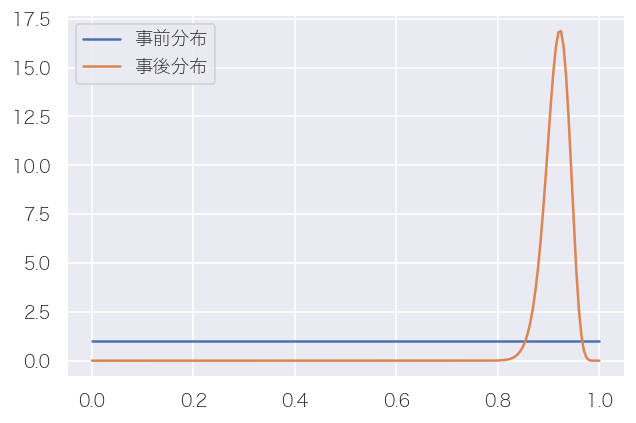

観測データの回答率0.9224806201550387
幸福と回答する確率：0.916030534351145
幸福と回答する確率の95%信用区間[0.86308488 0.95700201]


In [2]:
# 幸福度データで考える
n = 129 # アンケートした人数
y_sum = 119 # 幸福と回答した人の数

# 事前分布としてa=1、b=1のベータ分布(一様分布)を考える
a = 1
b = 1

# 事後分布のベータ分布のパラメータは以下になることが知られている
a_posterior = a+y_sum
b_posterior = b+n-y_sum
beta_dist_pre = beta(a, b)
# 何%の人が幸福と回答するか？を表すθの事後分布が手に入る
beta_dist_pos = beta(a_posterior, b_posterior)
ls = np.linspace(0, 1, 200)
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
ax.plot(ls, beta_dist_pre.pdf(ls), label="事前分布")
ax.plot(ls, beta_dist_pos.pdf(ls), label="事後分布")
plt.legend()
plt.show()

# 予測
print(f"観測データの回答率{y_sum/n}")
# 観測データを踏まえて、Y=1となる確率
print(f"幸福と回答する確率：{beta_dist_pos.mean()}")
print(f"幸福と回答する確率の95%信用区間{beta_dist_pos.ppf([0.025, 0.975])}")

## 3.2 ポアソンモデル
確率変数Yの予測モデルがポアソン分布と考えられるとき
- 同時確率密度関数P(y1..yn|θ)はパラメータθの元で各確率変数の確率密度の積で表される
- 同時確率密度関数と共役な分布として、パラメータθの事前分布はガンマ分布が考えられる
- なので事後分布はガンマ分布になる
- 予測分布p(y~ | y1..yn)は負の二項分布に従う

大卒の事後分布の95%信用区間[1.70494315 2.22267902]
非大卒の事後分布の95%信用区間[1.17343691 1.89083626]


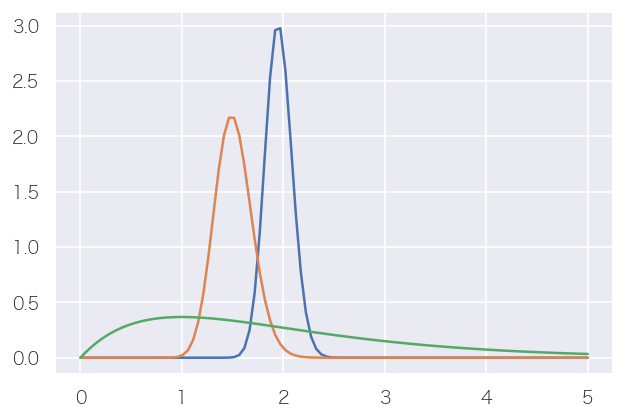

In [3]:
#ガンマ分布(事前分布)のパラメータを決定
a = 2
b = 1

# サンプルデータの定義
n1 = 111 # 大卒で子供を持っている人の数
sy1 = 217 # 大卒の人の数
n2 = 44 # 非大卒で子供を持っている人の数
sy2 = 66 # 非大卒の人の数

# 大卒の事後分布
a1_posterior = a+sy1
b1_posterior = b+n1
mu_posterior = a1_posterior / b1_posterior # 事後分布の期待値はこうなる
gamma_dist1 = gamma(a1_posterior, scale=1/b1_posterior)
print(f"大卒の事後分布の95%信用区間{gamma_dist1.ppf([0.025, 0.975])}")

# 非大卒の事後分布
a2_posterior = a+sy2
b2_posterior = b+n2
mu_posterior = a2_posterior / b2_posterior # 事後分布の期待値はこうなる
gamma_dist2 = gamma(a2_posterior, scale=1/b2_posterior)
print(f"非大卒の事後分布の95%信用区間{gamma_dist2.ppf([0.025, 0.975])}")

ls = np.linspace(0, 5, 100)
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
ax.plot(ls, gamma_dist1.pdf(ls))
ax.plot(ls, gamma_dist2.pdf(ls))
ax.plot(ls, gamma(a, scale=1/b).pdf(ls))
plt.show()

## 4.1 モンテカルロ法
- あるパラメータθの事後分布が分かっているとき、サンプルサイズを大きくして事後分布からのサンプルを得たとき、その経験分布を事後分布に近似することができる

In [4]:
# 学士号を持っている人に子供の数を聞いたとする
n = 44 # n人に聞いた
sy = 66 # n人に聞いた子供の数の総和
a = 2 # 事前分布に使うガンマ分布のパラメータ
b = 1

# この場合事後分布はa=a+sy、b=b+nのガンマ分布に従うことが知られている
gamma_dist = gamma(a+sy, scale=1/(b+n))

print(f"事後分布の真の期待値{gamma_dist.mean()}")
# 事後分布からサンプリングして平均を出すことで期待値を求める
print(f"サンプルサイズ10の時の平均{np.mean(gamma_dist.rvs(10))}")
print(f"サンプルサイズ1000の時の平均{np.mean(gamma_dist.rvs(1000))}")

print(f"事後分布の真の95%信用区間{gamma_dist.ppf([0.025, 0.975])}")
print(f"サンプルサイズ10の時の95%信用区間{np.quantile(gamma_dist.rvs(10), [0.025, 0.975])}")
print(f"サンプルサイズ1000の時の95%信用区間{np.quantile(gamma_dist.rvs(1000), [0.025, 0.975])}")

事後分布の真の期待値1.511111111111111
サンプルサイズ10の時の平均1.5717036278863896
サンプルサイズ1000の時の平均1.510335980278886
事後分布の真の95%信用区間[1.17343691 1.89083626]
サンプルサイズ10の時の95%信用区間[1.36450877 1.73572434]
サンプルサイズ1000の時の95%信用区間[1.17527099 1.92121239]


## 4.2 任意の関数に対する事後推測

0.05142244261467483


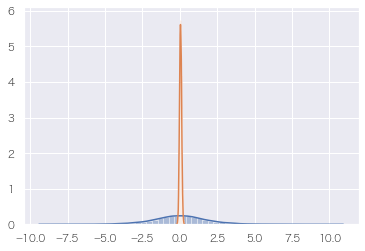

In [5]:
# 裁判所の判決に同意する人の数が二項分布に従う、その対数オッズに興味がある
a = 1
b = 1

# 事前分布のみでだけで対数オッズの事後分布を知る
beta_prior_dist = beta(a, b)
theta_prior_mc = beta_prior_dist.rvs(10000)
gamma_prior_mc = np.log(theta_prior_mc / (1-theta_prior_mc))

# 860人のうち441人が判決に同意したというデータを想定
n0 = 860-441
n1 = 441
beta_post_dist = beta(a+n1, b+n0) # 何%が同意するかのパラメータθの事後分布が求まる
theta_post_mc = beta_post_dist.rvs(10000) # 事後分布からθをサンプリング
gamma_post_mc = np.log(theta_post_mc / (1-theta_post_mc)) # サンプリングしたθを使ってオッズを計算
print(np.mean(gamma_post_mc))

fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
sns.distplot(gamma_prior_mc, ax=ax)
sns.distplot(gamma_post_mc, ax=ax)
plt.show()

## 5.3 平均と分散の同時推定
- θの事前分散が母分散σ^2に比例すると考える場合(事前にk0個サンプリングをしており、その標本平均の標準偏差σ^2/k0を事前分散と考える)、パラメータσの事後分布は逆ガンマ分布に従い、その事後パラメータも知られている
- 比例しないと考える場合(パラメータによってはサンプリングが簡単でない分布になることがある)の対処法は6章

In [6]:
# 事前分布
mu0 = 1.9 # パラメータθの事前平均
k0 = 1 # パラメータσの事前パラメータ
s20 = 0.010 # パラメータθの事前分散
nu0 = 1 # パラメータσの事前パラメータ

# 羽虫の羽の長さデータ
y = np.array([1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08])
n = len(y)
ybar = np.mean(y)
s2 = np.var(y)

# 事後推測
kn = k0 + n
nun = nu0 + n
mun = (k0*mu0 + n*ybar) / kn # パラメータθの事後平均
s2n = (nu0*s20 + n*s2 + k0*n/kn*(ybar-mu0)**2) / nun # パラメータσの事後平均

print(mun)
print(s2n)
print(np.sqrt(s2n))

1.814
0.015324
0.12379014500355026


## 6.2 離散近似
- θの事前分散が母分散σ^2に比例しないと考える時の対処法1
- p(θ,σ|y1〜yn) = p(θ,σ,y1〜yn) / p(y1〜yn)
- あるパラメータでどっちが起こりやすいかは上の式を割り算して、p(θ',σ',y1〜yn) / p(θ,σ,y1〜yn)で求められる
- p(θ,σ,y1〜yn) = p(θ) * p(σ) * p(y1〜yn|θ,σ)、つまりθの事前分布とσの事前分布とyの同時確率密度が分かればパラメータ候補の中でどれが起こりやすいかは計算することができる
- なので、θとσの候補をグリッドサーチして確率密度が高くなるものを探す

In [7]:
# 事前分布
mu0 = 1.9 # パラメータθの事前平均
t20 = 0.95**2 # パラメータθの事前分散
s20 = 0.010 # パラメータσの事前パラメータ
nu0 = 1 # パラメータσの事前パラメータ
G = 100
H = 100
# 羽虫の羽の長さデータ
y = np.array([1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08])

mean_grid = np.linspace(1.505, 2.00, G)
prec_grid = np.linspace(1.75, 175, H)

post_grids = []

for g in range(G):
    for h in range(H):
        post_grid = norm.pdf(mean_grid[g], loc=mu0, scale=np.sqrt(t20)) * \
        gamma.pdf(prec_grid[h], nu0/2, scale=2/(s20*nu0)) * \
        np.prod(norm.pdf(y, mean_grid[g], scale=1/np.sqrt(prec_grid[h])))
        
        post_grids.append([post_grid, mean_grid[g], prec_grid[h]])
        
post_grids = pd.DataFrame(post_grids, columns=["post_grid", "mean_grid", "prec_grid"])
post_grids["post_grid"] = post_grids["post_grid"] / np.sum(post_grids["post_grid"])

post_grids.sort_values("post_grid", ascending=False).head()

,post_grid,mean_grid,prec_grid
6031,0.001141,1.805,56.00
6030,0.001141,1.805,54.25
6032,0.001137,1.805,57.75
6029,0.001136,1.805,52.50
5930,0.001135,1.800,54.25


## 6.4 ギブスサンプリング
- θの事前分散が母分散σ^2に比例しないと考える時の対処法2
- 興味のあるパラメータ以外の全ての変数で条件付けた確率分布からパラメータを順番にサンプリングして、同時事後分布を求めるアルゴリズムをギブスサンプリングという

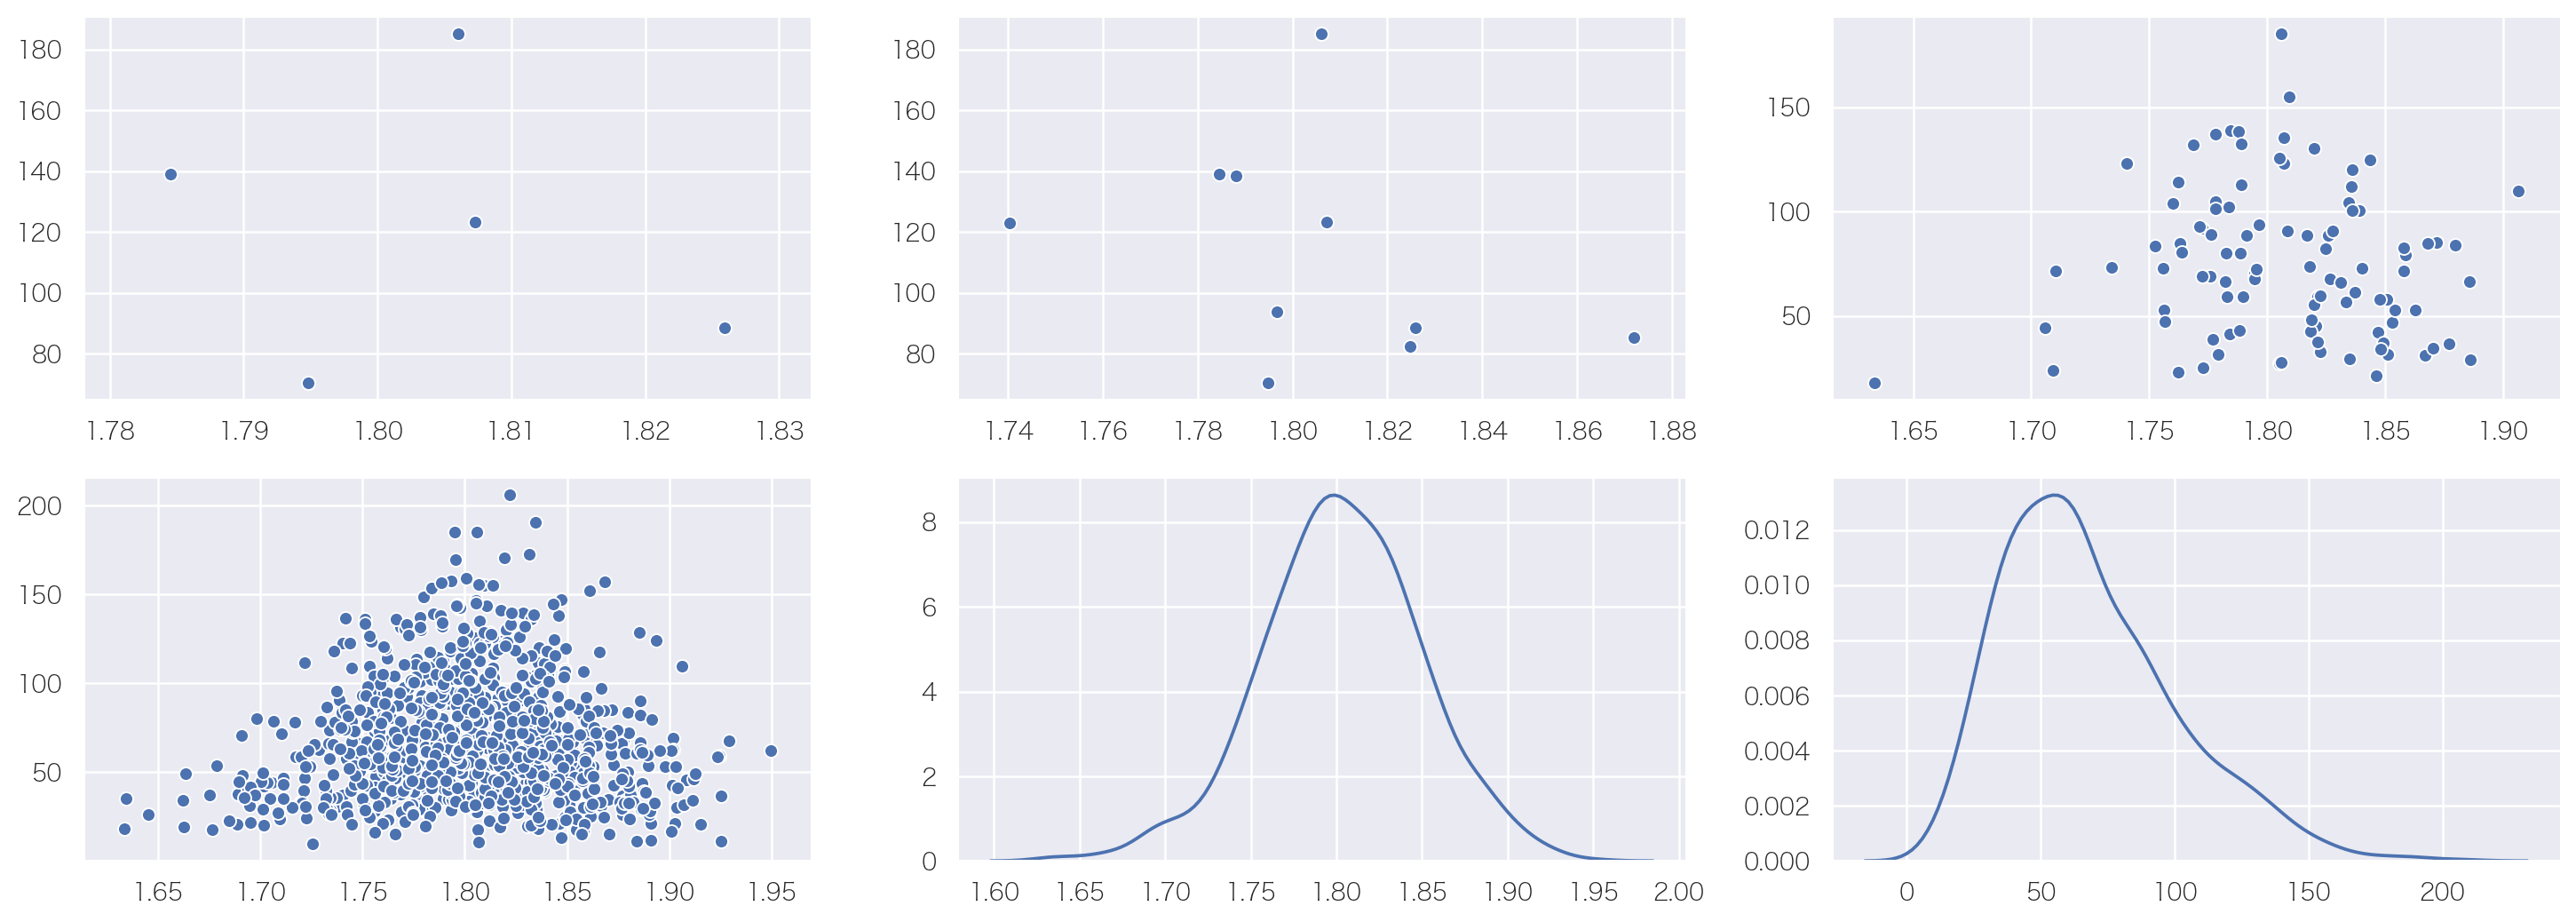

In [9]:
# 羽虫の羽の長さデータ
y = np.array([1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08])
mean_y = np.mean(y)
var_y = np.var(y)
n = len(y)

S = 1000
phi = [mean_y, 1/var_y] # 標本平均と精度(1/標本分散)を初期値とする
theta_list = []
sigma_list = []

for _ in range(1, S):
    mun = (mu0/t20 + n*mean_y*phi[1]) / (1/t20 + n*phi[1]) # θの事後期待値
    t2n = 1/(1/t20 + n*phi[1]) # θの事後分散
    theta = norm.rvs(loc=mun, scale=np.sqrt(t2n), size=1)[0] # θの事後分布(正規分布)のパラメータ分かったのでそこからサンプリング
    theta_list.append(theta)
    phi[0] = theta
    
    # θが既知の場合精度(1/分散)の分布は逆ガンマ分布になる
    nun = nu0 + n
    s2n = (nu0*s20 + (n-1)*var_y + n*(mean_y-phi[0])**2) / nun 
    sigma = gamma.rvs(a=nun/2, scale=2/(nun*s2n), size=1)[0] # σの事後分布からサンプリング
    sigma_list.append(sigma)
    phi[1] = sigma

fig = plt.figure(figsize=(20, 7), dpi=180)
ax1 = fig.add_subplot(231)
sns.scatterplot(theta_list[:5], sigma_list[:5], ax=ax1)
ax2 = fig.add_subplot(232)
sns.scatterplot(theta_list[:10], sigma_list[:10], ax=ax2)
ax3 = fig.add_subplot(233)
sns.scatterplot(theta_list[:100], sigma_list[:100], ax=ax3)
ax4 = fig.add_subplot(234)
sns.scatterplot(theta_list, sigma_list, ax=ax4)
ax5 = fig.add_subplot(235)
sns.kdeplot(data=theta_list, ax=ax5)
ax6 = fig.add_subplot(236)
sns.kdeplot(data=sigma_list, ax=ax6);

## 7.4 平均ベクトルと共分散行列のギブスサンプリング
- 多次元正規分布
- 最後二つの確率は解釈が異なることに注意
  - １つ目の確率は受講後の期待値が受講前の期待値より差がどんな小さい値であったとしても大きい確率を示している
  - もし差が僅差であった場合、受講後の期待値が高くてもサンプリングした際に受講後のサンプル点数が受講前のサンプル点数より大きくなるとは限らないため2つ目の確率は1つ目より小さくなると考えられる

受講後のテストの点の差の95%信用区間：[ 1.22746725  6.55223434 11.79455631]
サンプル中で事後分布θの受講前の期待値より受講後の期待値の方が大きくなる確率0.992
サンプリングしたθとσから受講前の点数と受講後の点数をサンプリングした際に受講後の方が点数が高くなる確率：0.7004


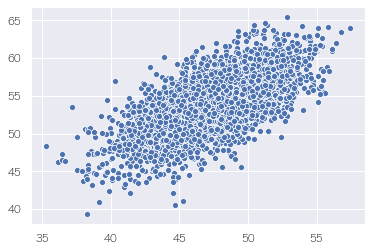

In [118]:
mu0 = np.array([50, 50]) # 事前平均
L0 = np.array([[625, 312.5], [312.5, 625]])
nu0 = 4
S0 = np.array([[625, 312.5], [312.5, 625]])

Y = np.array([[59, 43, 34, 32, 42, 38, 55, 67, 64, 45, 49, 72, 34, 
70, 34, 50, 41, 52, 60, 34, 28, 35],[77, 39, 46, 26, 38, 43, 68, 
86, 77, 60, 50, 59, 38, 48, 55, 58, 54, 60, 75, 47, 48, 33]])

n = Y.shape[1]
ybar = np.mean(Y, axis=1)
Sigma = np.cov(Y)
THETA = []
SIGMA = []
preds = []

for _ in range(5000):
    # thetaの更新
    Ln = np.linalg.inv(np.linalg.inv(L0) + n*np.linalg.inv(Sigma))
    mun = Ln@(np.linalg.inv(L0)@mu0 + n*np.linalg.inv(Sigma)@ybar)
    theta = multivariate_normal.rvs(mean=mun, cov=Ln)
    theta = theta.reshape(-1, 2)
    
    # Sigmaの更新
    Sn = S0 +  (Y.T-theta).T @ (Y.T-theta)
    Sigma = np.linalg.inv(wishart.rvs(df=nu0+n, scale=np.linalg.inv(Sn)))
    
    THETA.append(theta.reshape(-1,))
    SIGMA.append(Sigma)
    
    preds.append(multivariate_normal.rvs(mean=theta.reshape(-1,), cov=Sigma))
    
THETA = np.array(THETA)
SIGMA = np.array(SIGMA)
preds = np.array(preds)
sns.scatterplot(x=THETA[:,0], y=THETA[:,1]);
print(f"受講後のテストの点の差の95%信用区間：{np.quantile(THETA[:,1]-THETA[:,0], [0.025, 0.5, 0.975])}")
print(f"サンプル中で事後分布θの受講前の期待値より受講後の期待値の方が大きくなる確率{np.mean(THETA[:,1]>THETA[:,0])}")
print(f"サンプリングしたθとσから受講前の点数と受講後の点数をサンプリングした際に受講後の方が点数が高くなる確率：{np.mean(preds[:,1] > preds[:,0])}")

## 7.5欠測データの観測

In [ ]:
with open("../data/diabetes_200_miss.dat.txt") as f:
    data = f.readlines()
data = [d[:-1].split() for d in data]
df = pd.DataFrame(data, columns=["glu", "bp", "skin", "bmi"]).drop(0).replace("NA", np.nan)
df.head()

In [ ]:
# 事前分布のパラメータ
n = df.shape[0]
p = df.shape[1]

mu0 = np.array([120, 64, 26, 26]) # 事前平均
sd0 = mu0 / 2

L0 = np.ones((p, p)) * 0.1
for i in range(len(L0)):
    L0[i][i] = 1
L0 = np.outer(sd0, sd0) * L0
nu0 = p+2
S0 = L0

# 初期値
sigma = S0
Y_full = df.copy()
O = Y_full.isna().to_numpy() * 1
